# Classification of cat images with Multi-Layer (Deep) Neural Network

This is the second part of Programming Assignment 2 (PA2)! 

In this part, you will use the functions you just implemented in the first part and build a deep network to classify cat images (being cat or non-cat). You are expected to notice an improvement in accuracy relative to your previous logistic regression implementation from PA1.  


<div class="alert alert-warning" markdown="1">
    <strong>After this assignment, you should be able to:</strong>
    <ul> 
        <li>Build and apply a deep (multi-layer) neural network for supervised learning.</li>
    </ul>
</div>


## 1 - Packages

Lets import the packages that we will use in this assignment first:

In [31]:
%%capture
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
# make sure you have utils2.py file included in your folder 
# and that it includes all the needed helper functions tthat you implemented in Part1.
from utils2 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.random.seed(1)

## 2 - Dataset

Use the same "Cat vs non-Cat" dataset from the PA1 (previous assignment). The model you had built there had 70% test accuracy. By using more layers, your new model should perform better!

**Problem Statement**: You are given a dataset containing:
  - a training set of m_train images labelled as cat (with label = 1) or non-cat (with label = 0)
  - a test set of m_test images where each image is labelled as being a cat image or a non-cat image.
  - each image is of shape (num_px, num_px, 3) where 3 is for the 3 color channels (RGB).

Let's remember the dataset first. Below, load the dataset first and then show a sample image from the dataset.

In [32]:


def dataloader():
    train_dataset = h5py.File('data/train.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('data/test.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes







train_x_orig, train_y, test_x_orig, test_y, classes = dataloader()

The following code will show you a sample image from the training set. Feel free to change the index and re-run the cell to see different images from the dataset. 

y = 0. This is a non-cat picture.


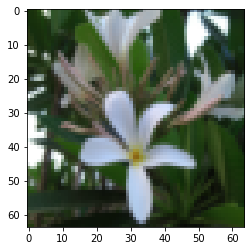

In [33]:
# Example of a picture
index = 9
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". This is a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [34]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


First, reshape (i.e., convert the image data into a vector) and standardize (normalize) all the images before feeding them to the network. The code for that purpose is given below.


In [35]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


$12,288$ equals to: $64 \times 64 \times 3$ which is the size of one image vector after reshaped.

## 3 - Architecture of your model

Now, build a deep neural network to distinguish cat images from non-cat images.

In this part of the assignment, you will build two different models:
- A 2-layer neural network
- An L-layer deep neural network

You will then compare the performance of these models. 

### 3.1 - Two-layer neural network

<img src="images/2layerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 2</u>: Two-layer neural network. <br> The complete NN architecture can be summarized as: ***INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT***. </center></caption>

<u>Detailed Architecture of figure 2</u>:
- The input is a (64,64,3) dimensional image which is flattened to a vector of dims: $(12288,1)$. 
- The corresponding (flattened image) vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- Also add a bias term and then pass that from relu to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- Repeat the same processes describe above for the next layer:
- You multiply the resulting vector by $W^{[2]}$ and add your bias. 
- Finally, you take the sigmoid of the result. If the value is greater than 0.5, you classify that image as cat.

### 3.2 - L-layer deep neural network

It is easier to represent larger networks (L-layer deep neural network) in a more abstract way as shown below:

<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 3</u>: L-layer neural network. <br> The L-layer NN architecture (the complete model) can be summarized as: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

<u>Detailed Architecture of figure 3</u>:
- The input is a (64,64,3) dimensional image which is flattened into a vector of dims: (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then first multiplied by the weight matrix $W^{[1]}$ and then added to the bias: $b^{[1]}$. The result is called the linear unit output (z).
- Next, you apply the relu on the linear unit output. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture (if you use relu for activation).
- Finally, you take the sigmoid of the final linear unit output. If it is greater than 0.5, you classify that corresponding image as cat.

### 3.3 - General methodology

The following first two steps summarize the processes for 'training' a neural network and the last step (step 3) is used for 'testing' a neural network:
    1. Initialize parameters / Define hyperparameters
    2. Loop for num_iterations:
        a. Forward propagation
        b. Compute cost function
        c. Backward propagation
        d. Update parameters (using parameters, and grads from backprop) 
    3. Use trained parameters to predict labels

Let's now implement those two models next!

## 4 - Two-layer neural network


<div class="alert alert-info"><h2>Exercise 1</h2>
<p> By using the helper functions you have already implemented in the previous part, build a 2-layer neural network with the following structure (model): `linear -> relu -> linear -> sigmoid`.</p>
</div>

The functions you may need and their inputs are:

```python
def initialize_parameters(n_x, n_h, n_y):
    # ...
    return parameters 

def linear_activation_forward(A_prev, W, b, activation):
    # ...
    return A, cache

def compute_cost(AL, Y):
    # ...
    return cost

def linear_activation_backward(dA, cache, activation):
    # ...
    return dA_prev, dW, db

def update_parameters(parameters, grads, learning_rate):
    # ...
    return parameters
```

In [36]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [37]:
# GRADED FUNCTION: two_layer_model

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    
    ### START CODE HERE ### (≈ 1 line of code)
    parameters =  initialize_parameters(n_x, n_h, n_y)
    ### END CODE HERE ###
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        
        ### START CODE HERE ### (≈ 2 lines of code)
        A1, cache1 = linear_activation_forward(X, W1, b1, 'relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, 'sigmoid')
        ### END CODE HERE ###
        
        # Compute cost
            
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(A2, Y)
        ### END CODE HERE ###
        
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        
        ### START CODE HERE ### (≈ 2 lines of code)
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, 'sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, 'relu')
        
        
        ### END CODE HERE ###
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        ### START CODE HERE ### (approx. 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {:4d}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    
    
    return parameters

Now you are ready to train your network. Notice how long it takes to run your model and train it. The cost should be decreasing. It may take up to 5 minutes to run 2500 iterations. Check if the "Cost after iteration 0" matches the expected output below. If not, click on the square (⬛) on the upper bar of this notebook to stop the cell and fix your error.

Cost after iteration    0: 0.693049735659989
Cost after iteration  100: 0.6464320953428849
Cost after iteration  200: 0.6325140647912677
Cost after iteration  300: 0.6015024920354665
Cost after iteration  400: 0.5601966311605747
Cost after iteration  500: 0.5158304772764729
Cost after iteration  600: 0.47549013139433266
Cost after iteration  700: 0.4339163151225749
Cost after iteration  800: 0.40079775362038866
Cost after iteration  900: 0.3580705011323798
Cost after iteration 1000: 0.3394281538366413
Cost after iteration 1100: 0.3052753636196264
Cost after iteration 1200: 0.2749137728213015
Cost after iteration 1300: 0.2468176821061484
Cost after iteration 1400: 0.1985073503746611
Cost after iteration 1500: 0.17448318112556663
Cost after iteration 1600: 0.17080762978097372
Cost after iteration 1700: 0.113065245621647
Cost after iteration 1800: 0.09629426845937149
Cost after iteration 1900: 0.08342617959726865
Cost after iteration 2000: 0.07439078704319085
Cost after iteration 2100: 0.

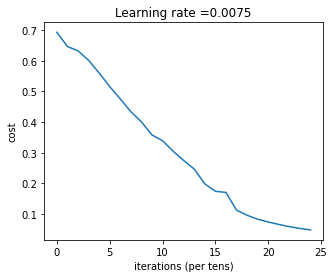

In [38]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

**Expected Output**:
```
Cost after iteration    0: 0.6930497356599888
Cost after iteration  100: 0.6464320953428849
...
Cost after iteration 2400: 0.048554785628770206
```

It is good that you built a vectorized implementation! Otherwise, it might have taken 10 times longer to train that NN.

Now, you can use the trained parameters to classify all the images in the dataset. To see your predictions on both the training and test sets, run the cell below.

In [39]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


**Expected Output**:
```
Accuracy: 1.0
```

In [40]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


**Expected Output**:
```
Accuracy: 0.72
```

**Note**: You may notice that running the model on fewer iterations (say 1500) gives better accuracy on the test set. This is typically called "early stopping" and we talked about that in the class already. Early stopping is a way to avoid overfitting.

Great! Your 2-layer neural network has better performance (72%) than the logistic regression implementation from the last assignment (70%). Let's see if a $L$-layer model (where $L>2$) could do even better.

## 5 - L-layer Neural Network


<div class="alert alert-info"><h2>Exercise 2</h2>
<p> Use the helper functions you have already implemented and build an $L$-layer neural network with the following structure (model): `[linear -> relu]`$\times$`(L-1) -> linear -> sigmoid`.</p>
</div>


The functions you may need and their inputs are:
```python
def initialize_parameters_deep(layers_dims):
    # ...
    return parameters

def L_model_forward(X, parameters):
    # ...
    return AL, caches

def compute_cost(AL, Y):
    # ...
    return cost

def L_model_backward(AL, Y, caches):
    # ...
    return grads

def update_parameters(parameters, grads, learning_rate):
    # ...
    return parameters
```

In [41]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [42]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [linear -> relu]*(L-1) -> linear -> sigmoid.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X, parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads =  L_model_backward(AL, Y, caches)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {:4d}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

You will now train the model as a 4-layer neural network ($L=4$). 

Run the cell below and train your 4-layer model. The cost should decrease at each iteration. It may take up to 5 minutes to run 2500 iterations. Check if the "Cost after iteration 0" matches the expected output below, if not, click on the square (⬛) on the upper bar of this notebook to stop the cell and debug/fix your error.

Cost after iteration    0: 0.7717493284237686
Cost after iteration  100: 0.6720534400822913
Cost after iteration  200: 0.6482632048575212
Cost after iteration  300: 0.6115068816101354
Cost after iteration  400: 0.567047326836611
Cost after iteration  500: 0.5401376634547801
Cost after iteration  600: 0.5279299569455267
Cost after iteration  700: 0.46547737717668514
Cost after iteration  800: 0.369125852495928
Cost after iteration  900: 0.39174697434805356
Cost after iteration 1000: 0.3151869888600615
Cost after iteration 1100: 0.2726998441789385
Cost after iteration 1200: 0.23741853400268137
Cost after iteration 1300: 0.19960120532208644
Cost after iteration 1400: 0.18926300388463305
Cost after iteration 1500: 0.1611885466582775
Cost after iteration 1600: 0.14821389662363316
Cost after iteration 1700: 0.13777487812972944
Cost after iteration 1800: 0.1297401754919012
Cost after iteration 1900: 0.12122535068005211
Cost after iteration 2000: 0.1138206066863371
Cost after iteration 2100: 0

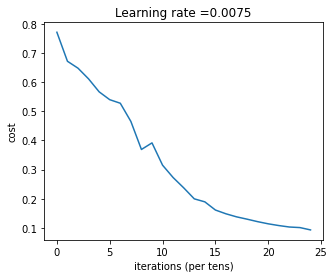

In [43]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

**Expected Output**:
```
Cost after iteration    0: 0.771749
Cost after iteration  100: 0.672053
...
Cost after iteration 2400: 0.092878
```

In [44]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9856459330143539


**Expected Output**:
```
Accuracy: 0.985645933014
```

In [45]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


**Expected Output**:
```
Accuracy: 0.8
```

It seems that your 4-layer neural network has even better performance (80%) than your 2-layer neural network (72%) on the same test set. 

You can try different number of layers in your L-model NN to see if you can get even better numbers. But submit your results for  the case given above ($L=4$ case).

##  6) Results Analysis

Now, let's have a look at some misclassified images by the L-layer model. The code below will show a few mislabeled images. 

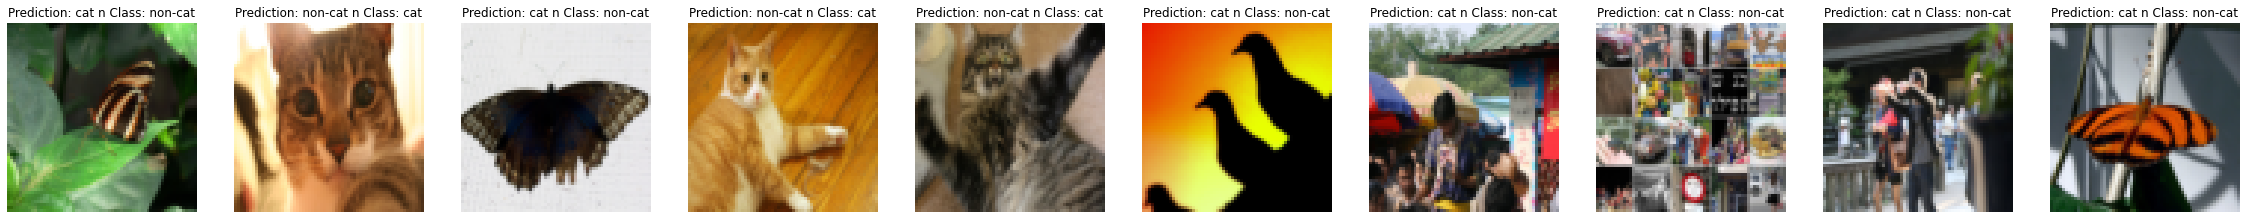

In [46]:
def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " n Class: " + classes[y[0,index]].decode("utf-8"))

print_mislabeled_images(classes, test_x, test_y, pred_test)

**A few types of images where the model tends to perform poorly in classification may include:** 
- Cat body being in an unusual position
- Cat appearing against a background of a similar color
- Unusual colors and species
- Camera angle
- Different brightness levels in the picture
- Scale variation (cat being very large or small in the image) 

## 7) Test with your own image (optional/ungraded exercise) ##

Congratulations on finishing this assignment as well. You can use your own image and see the output of your model. To do that:
  1. Click on "File" in the upper bar of this notebook, then click "Open" to go to the folder where you started your jupyter notebook (remember that, in jupyter notebook, you cannot go to higher folders).
  2. Add your image to this Jupyter Notebook's directory, in the "images" folder
  3. Edit the following code to include your image file's name 
  4. Run the code and see if the algorithm is classifying that image correctly (1 = cat, 0 = non-cat)!

In [47]:
## START CODE HERE ##
my_image = "my_image.jpg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)
## END CODE HERE ##

fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((num_px*num_px*3,1))
my_image = my_image/255.
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

AttributeError: module 'scipy.ndimage' has no attribute 'imread'